# RUN PERFORMANCE PROJECT - Pau Sampietro 

## *Predicting future races:* LINEAR REGRESSION ALGORITHM

To predict moving times for future races, we start applying a simple algorithm as LR, whose is pretty easy to understand and evaluate. In this notebook, we will fit two different models, one as a approximation and the second one as a predictor, only with the features 'distance' and 'accumulated ascent' as an inputs for the model. Then, we will predict and store the values for moving time for the scheduled races for Pau.

<img src="images/linear_regression.png">

*Example of fitting data with linear regression*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.plotly as py
import matplotlib.pyplot as plt
import cufflinks as cf 
from ipywidgets import interact
import plotly.graph_objs as go
from rpdb import read_table, read_table_sql, export_table
from datetime import datetime

#### Import table moves from Pau from the Database

In [2]:
Ssql = "SELECT * FROM moves WHERE athlete = 'P'"
moves = read_table_sql('moves', Ssql)

### 1. Adding/Droping some Features, filtering track runs

#### 1.1. Adding 'days_from' column with the days since the run has been done

In [3]:
moves['days_from'] = moves.apply(lambda x: (datetime.now() - x['start_time']).days, axis = 1)

#### 1.2. Filtering only relevant features

In [4]:
moves_fil = moves.drop(columns = 'index').reset_index()
moves_fil = moves_fil[['distance','accum_ascent','ascent_ratio','calories','heart_rate','days_from','moving_time']]
moves_fil.head()

,distance,accum_ascent,ascent_ratio,calories,heart_rate,days_from,moving_time
0,4019.0,280.0,69.7,670.0,166.0,660,29.8
1,4995.0,63.0,12.6,585.0,168.0,660,30.9
2,4374.0,115.0,26.3,602.0,180.0,642,22.6
3,3005.0,91.0,30.3,365.0,167.0,641,16.9
4,6540.0,241.0,36.9,760.0,161.0,637,42.0


In [5]:
len(moves_fil)

143

* ***We store the table with the appropiate features in order to perform further regressions in other notebooks (4b, 4c...)***

In [9]:
export_table(moves_fil, 'moves_feat', METHOD='replace')

### 2. Preliminar Pairplot of features & Heatmap 

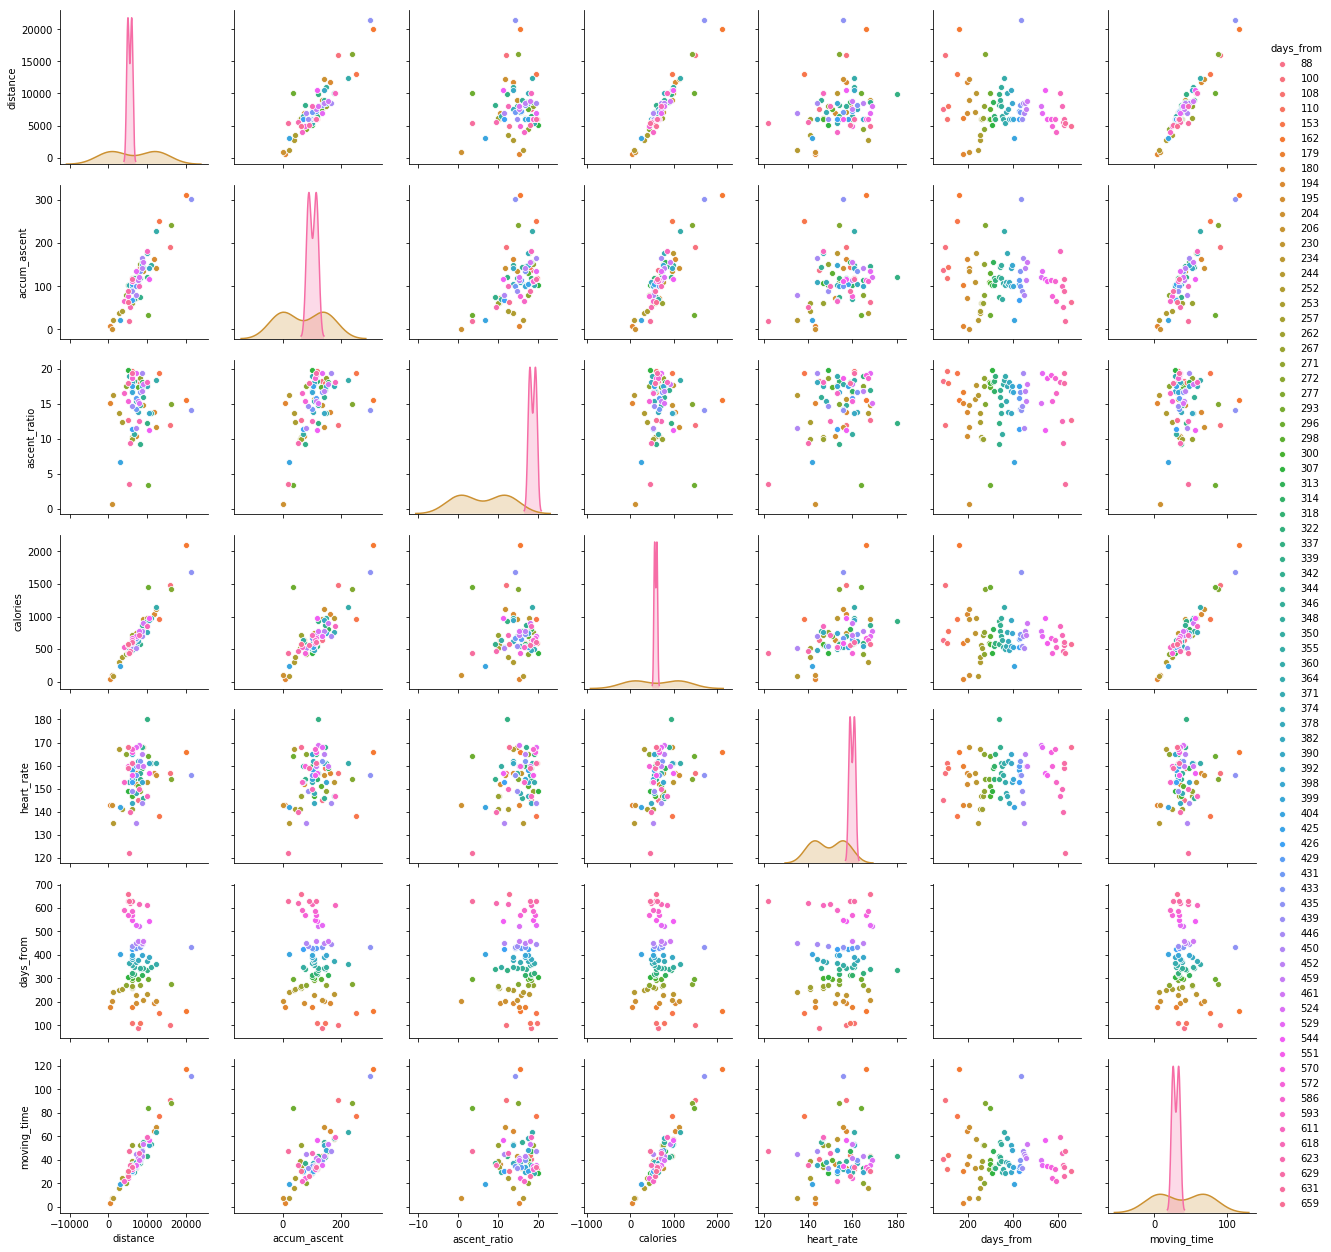

In [67]:
sns.pairplot(moves_fil, hue='days_from')

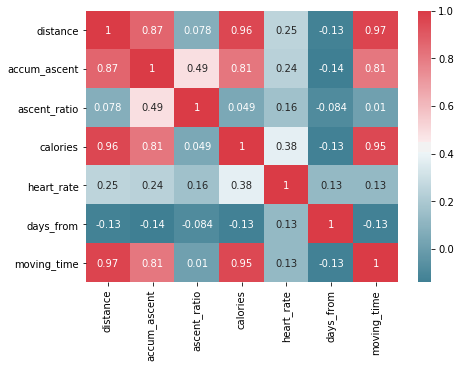

In [70]:
corr = moves_fil.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True))

### 3. Linear Regression Algorithm

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

The goal is to know what will be the times for two given races:
* Delta Prat Race: 10 km, 25 m ascent, 5 may 2019
* Marathon Catllaràs: 42 km, 2700 m ascent, 19 may 2019
* Stockholm Marathon: 42 km, 172 m ascent, 1 june 2019
* Trail Ulldeter: 21 km, 1300 m ascent, 23 june 2019

In [7]:
races_names = pd.Series(['delta prat', 'catllaras', 'stockholm', 'ulldeter'])
races_dist = pd.Series([10000.0, 42300.0, 42195.0, 21000.0])
races_asc = pd.Series([25.0, 2700.0, 172.0, 1300.0])
races_to = pd.Series([-13, -27, -40, -62])

races = pd.DataFrame({'name': races_names, 'distance': races_dist, 'accum_ascent': races_asc, 'days_from': races_to})
races

,name,distance,accum_ascent,days_from
0,delta prat,10000.0,25.0,-13
1,catllaras,42300.0,2700.0,-27
2,stockholm,42195.0,172.0,-40
3,ulldeter,21000.0,1300.0,-62


* Store races DataFrame for further analysis

In [8]:
export_table(races, 'races')

#### 3.1. Applying linear regression with all the features

In [9]:
X = moves_fil.drop(columns='moving_time')
y = moves_fil['moving_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 32)

In [10]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# predictions done with the model
y_pred = linear_reg.predict(X_test)

In [11]:
# The coefficients
print('Coefficients:', linear_reg.coef_)
# Printing the metrics for the model
print("* Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('* Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: [ 2.45590857e-04 -2.87972571e-03  1.03254263e-01  6.98069053e-02
 -9.33213380e-01  6.97405533e-03]
* Mean squared error: 46.55
* Variance score: 0.97


*As we can see, the result of the r2 score is very high. That means the data is well explained by the model, but we still have a mean squared error quite big. This model is probably overfitting our data, and will not be able to generalize pretty well future given inputs.*

* Performing **cross-validation** score

In [12]:
scores = cross_val_score(linear_reg, X,  y, cv=5)
print(f'* CV scores: {scores}')
print('* Mean Variance score: %.2f' % scores.mean())

* CV scores: [0.89073938 0.95834774 0.97700248 0.95086668 0.95433902]
* Mean Variance score: 0.95


#### 3.2. Model with only two features: Distance & Accumulated ascent

In [13]:
X = moves_fil[['accum_ascent','distance']]
y = moves_fil['moving_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 32)

In [14]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# predictions done with the model
y_pred = linear_reg.predict(X_test)

In [15]:
# The coefficients
print('Coefficients:', linear_reg.coef_)
# Printing the metrics for the model
print("* Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('* Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: [0.11677722 0.00338874]
* Mean squared error: 154.32
* Variance score: 0.89


In [16]:
scores = cross_val_score(linear_reg, X,  y, cv=5)
print(f'* CV scores: {scores}')
print('* Mean Variance score: %.2f' % scores.mean())

* CV scores: [0.70754061 0.91185059 0.94255492 0.84742461 0.84566975]
* Mean Variance score: 0.85


#### 3.3. Calculating predictions for next given races with actual model:

In [17]:
linear_reg.fit(X, y)

races_lr_pred = linear_reg.predict(races[['accum_ascent','distance']])
print(f'* LR predictions for given races: {races_lr_pred}')

* LR predictions for given races: [ 36.63950814 452.95048311 163.87062203 219.99027765]


* Including results of linear regression predictions in the races dataframe

In [21]:
races = read_table('races')
races['lr_pred'] = races_lr_pred
export_table(races.drop(columns='index'), 'races')

*** *COMMENTS***: Althought the r2 score of this model is pretty high, the results above show that there are a misunderstanding of some data from the linear model. The two main conlusions, based on our knowledge of Pau's previous marks are:
* Cross-country races are predict very well. **Catllaras: 452 min ~ 7:30h / Ulldeter: 219 min ~ 3:45h** (last year time!)
* Urban races are badly predicted **36 min for a 10 km** and **2:45h for a marathon** are for professional athletes !!!